# Stock Price Indicator
## I. ETL Pipeline Preparation
### 1. Import libraries and load datasets.
- Import Python libraries
- Load data from Yahoo Finance (Accessing data from the Yahoo finance plattform via the corresponing API you are able to download data since 1950 (if the stock existed))

In [604]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf



In [605]:
# Import data from Yahoo finance

def get_data(symbols=['SPY'], start_date='2000-01-01', end_date='2020-12-31'):
    '''
    Setup of an empty dataframe with the given timeperiod as index to be used as instance for further gathered data.
    Then downloads the data from Yahoo Finance for the selected symbol(s) and time period and selects the Adj Close column
    INPUT: 
    symbols - list - symbols of listed stocks
    start_date - datetime - Beginning of the period to analyze
    end_date - datetime - End of the period to analyze
    
    OUTPUT
    df - dataframe - Dataframe containing the Adj Close for each symbol with the time period as index (ordered ascending)
    '''
    dates= pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_tmp = yf.download(symbol, start_date, end_date)
        df_tmp = df_tmp[['Adj Close']]
        df_tmp = df_tmp.rename(columns={"Adj Close": symbol})
        
        df = df.join(df_tmp)
        df = df.dropna()
    
    return df

In [660]:
data_analysis_df = get_data(symbols=['AAPL', 'VZ','GOLD', 'BIIB'], start_date='2016-01-01', end_date='2016-05-31')
data_analysis_df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,VZ,GOLD,BIIB
2016-01-04,24.364536,35.954697,7.347449,294.619995
2016-01-05,23.753977,36.448521,7.252643,296.700012
2016-01-06,23.289116,36.119225,7.527581,293.679993
2016-01-07,22.306208,35.920856,8.295506,284.010010
2016-01-08,22.424154,35.571724,7.982648,280.589996


### 2. Normalize data and plot to check for anomalies

In [661]:
# Noramlize the stock price data

def normalize_stock_data(df):
    df = df/df.iloc[0,:]
    return df

In [662]:
data_analysis_norm = normalize_stock_data(data_analysis_df)

In [663]:
# Plot stock price data and check for anomalies

def plot_stock_data(df):
    if isinstance(df, pd.Series):
        plt.figure(figsize=(12,8))
        ax1 = df.plot()
        ax1.set_xlabel('time')
        ax1.set_ylabel('price')
        ax1.set_title('Stock price development')
        plt.legend(loc='upper right')
        plt.show()
    else:
        plt.figure(figsize=(12,18))
        ax2 = plt.subplot(2,1,1)
        ax2.set_xlabel('time')
        ax2.set_ylabel('price')
        ax2.set_title('Absolute stock price development')
        for col in df.columns:
            df[col].plot()
    
        plt.legend(loc='upper right')

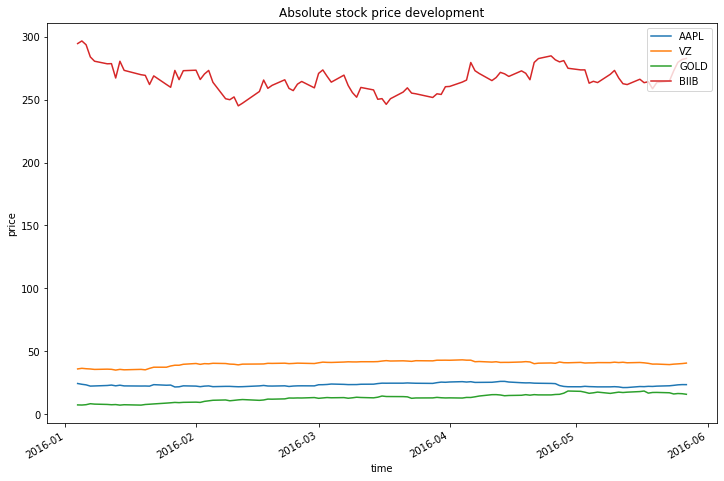

In [664]:
plot_stock_data(data_analysis_df)

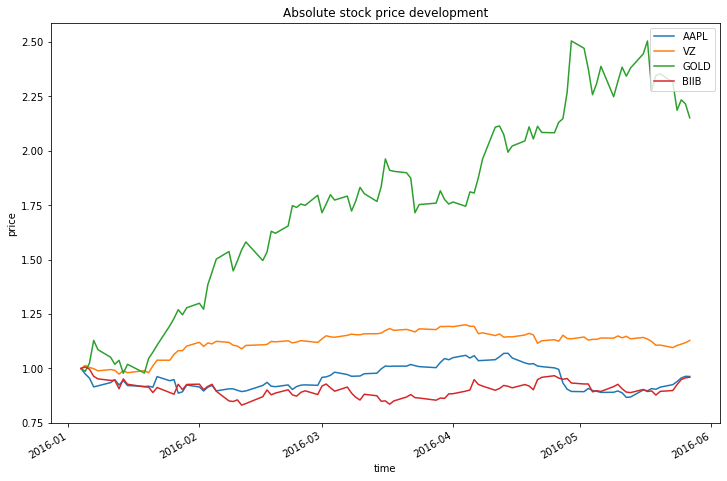

In [665]:
plot_stock_data(data_analysis_norm)

### 3. Feature engineering

In [666]:
# Simple moving average (SMA)

win = 20
sma_20 = data_analysis_norm.rolling(window=win).mean()
std_df = data_analysis_norm.rolling(window=win).std()
sma_20.tail()
std_df.tail()

,AAPL,VZ,GOLD,BIIB
2016-05-23,0.026644,0.014815,0.101612,0.023517
2016-05-24,0.018046,0.015941,0.096251,0.021420
2016-05-25,0.020742,0.015765,0.088734,0.021300
2016-05-26,0.024928,0.015843,0.091970,0.021646
2016-05-27,0.027952,0.015755,0.093227,0.023818


In [667]:
# Bollinger(R) Bands

def get_bollinger_bands(rm=sma_20, rstd=std_df):
    upper_band = rm + rstd*2
    lower_band = rm - rstd*2
    return upper_band, lower_band


In [668]:
b_upper_band, b_lower_band = get_bollinger_bands()
b_upper_band.tail()

,AAPL,VZ,GOLD,BIIB
2016-05-23,0.957293,1.162586,2.540562,0.958940
2016-05-24,0.937303,1.163880,2.532619,0.953258
2016-05-25,0.943844,1.161476,2.521914,0.952958
2016-05-26,0.955169,1.160672,2.525672,0.953806
2016-05-27,0.964664,1.160140,2.510544,0.959473


In [669]:
# Daily returns

def get_daily_returns(df=data_analysis_df):
    daily_returns = df.copy()
    daily_returns[1:] = (df[1:]/df[:-1].values) - 1
    daily_returns.iloc[0,:] = 0
    return daily_returns

In [670]:
daily_returns = get_daily_returns()
daily_returns.head()

,AAPL,VZ,GOLD,BIIB
2016-01-04,0.000000,0.000000,0.000000,0.000000
2016-01-05,-0.025059,0.013735,-0.012903,0.007060
2016-01-06,-0.019570,-0.009035,0.037909,-0.010179
2016-01-07,-0.042205,-0.005492,0.102015,-0.032927
2016-01-08,0.005288,-0.009719,-0.037714,-0.012042


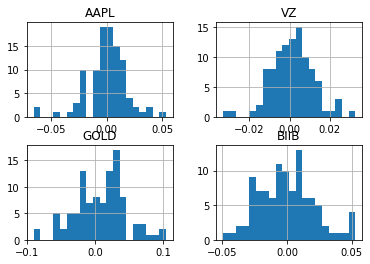

In [671]:
daily_returns.hist(bins= 20)
plt.show()

In [672]:
# MOMENTUM

def get_momentum(df=data_analysis_df, win=5):
    df_momentum = df.copy()
    df_momentum[win:] = (df[win:]/df[:-(win)].values) - 1
    df_momentum.iloc[0:(win),:] = 0
    return df_momentum

In [673]:
momentum = get_momentum()
momentum.tail()

,AAPL,VZ,GOLD,BIIB
2016-05-23,0.027162,-0.040796,-0.052882,-0.005296
2016-05-24,0.047171,-0.025933,-0.127000,0.035747
2016-05-25,0.053511,-0.010716,-0.019296,0.058307
2016-05-26,0.065924,0.010679,-0.056198,0.089981
2016-05-27,0.053875,0.019332,-0.085746,0.072556


In [674]:
momentum_10 = get_momentum(win=10)
momentum_10.head(15)

,AAPL,VZ,GOLD,BIIB
2016-01-04,0.000000,0.000000,0.000000,0.000000
2016-01-05,0.000000,0.000000,0.000000,0.000000
2016-01-06,0.000000,0.000000,0.000000,0.000000
2016-01-07,0.000000,0.000000,0.000000,0.000000
2016-01-08,0.000000,0.000000,0.000000,0.000000
2016-01-11,0.000000,0.000000,0.000000,0.000000
2016-01-12,0.000000,0.000000,0.000000,0.000000
2016-01-13,0.000000,0.000000,0.000000,0.000000
2016-01-14,0.000000,0.000000,0.000000,0.000000
2016-01-15,0.000000,0.000000,0.000000,0.000000


### 4. Merge all indicators and symbols into one datafrage

In [675]:
def create_indicator_dataframe(df):
    ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
        and joins all indicators to one dataframe 
        INPUT: 
        df - dataframe - contains the orginal data to analyse 
        OUTPUT:
        indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
    indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','SMA', 'Momentum', 'Upper Band','Lower Band'])
    
    for symbol in df.columns:
        df_temp = df[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
        df_temp['Symbol']= symbol

        df_temp = df_temp.join(daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
        df_temp = df_temp.join(sma_20[symbol], on='Date').rename(columns={symbol:'SMA'})
        df_temp = df_temp.join(b_upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
        df_temp = df_temp.join(b_lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
        df_temp = df_temp.join(momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})
        indicator_df = pd.concat([indicator_df, df_temp])
        
        indicator_df.fillna(method='ffill', inplace=True)
        indicator_df.fillna(method='bfill', inplace=True)
    
    return indicator_df

In [676]:
indicator_model_df = create_indicator_dataframe(data_analysis_df)
indicator_model_df

,Date,Symbol,Adj Close,Daily Returns,SMA,Momentum,Upper Band,Lower Band
0,2016-01-04,AAPL,24.364536,0.000000,0.933355,0.000000,0.987652,0.879058
1,2016-01-05,AAPL,23.753977,-0.025059,0.933355,0.000000,0.987652,0.879058
2,2016-01-06,AAPL,23.289116,-0.019570,0.933355,0.000000,0.987652,0.879058
3,2016-01-07,AAPL,22.306208,-0.042205,0.933355,0.000000,0.987652,0.879058
4,2016-01-08,AAPL,22.424154,0.005288,0.933355,0.000000,0.987652,0.879058
...,...,...,...,...,...,...,...,...
97,2016-05-23,BIIB,264.850006,0.004513,0.911905,-0.005296,0.958940,0.864871
98,2016-05-24,BIIB,272.940002,0.030546,0.910419,0.035747,0.953258,0.867579
99,2016-05-25,BIIB,279.700012,0.024767,0.910357,0.058307,0.952958,0.867757
100,2016-05-26,BIIB,282.000000,0.008223,0.910514,0.089981,0.953806,0.867221


In [678]:
indicator_model_df[indicator_model_df['Symbol']=='AAPL'].describe()

,Adj Close,Daily Returns,SMA,Momentum,Upper Band,Lower Band
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,23.282946,-0.000202,0.955931,0.000554,1.014841,0.897020
std,1.334249,0.017997,0.043860,0.037308,0.054690,0.048319
min,21.134403,-0.065707,0.901211,-0.112983,0.936277,0.817226
25%,22.166833,-0.007422,0.922059,-0.020485,0.968740,0.875486
50%,22.950366,0.000645,0.933355,0.000375,0.988601,0.879170
75%,24.543244,0.010515,0.992933,0.027109,1.069367,0.915808
max,26.066298,0.053167,1.038958,0.065924,1.122216,1.000371


### 5. Put all the above into one class

In [624]:
class StockDataAnalysis():
    ''' Creates a StockDataAnalysis object which is able to take one or mutiple stock symbols and a timeframe and then computes
        a range of indicators on the stock data and plots the results'''
    
    def __init__(self, symbols=['SPY'], start_date='2020-01-01', end_date='2021-04-16'):
        ''' Create an instance of StockDataAnalysis'''
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        
        self.data = get_data(self.symbols, self.start_date, self.end_date)
        self.data_norm = normalize_stock_data(self.data)
        
    # Plot stock price data and check for anomalies

    def plot_stock_data(self, normalized=True):
        if normalized:
            df = self.data_norm
            title_str = 'Relative stock price development'
        else:
            df = self.data
            title_str = 'Absolute stock price development'
        if isinstance(df, pd.Series):
            plt.figure(figsize=(12,8))
            ax1 = df.plot()
            ax1.set_xlabel('time')
            ax1.set_ylabel('price')
            ax1.set_title(title_str)
            plt.legend(loc='upper right')
            plt.show()
        else:
            plt.figure(figsize=(12,18))
            ax2 = plt.subplot(2,1,1)
            ax2.set_xlabel('time')
            ax2.set_ylabel('price')
            ax2.set_title(title_str)
            for col in df.columns:
                df[col].plot()
        
            plt.legend(loc='upper right')
           
    def calculate_rolling_stats(self, win=20):
        rm = self.data_norm.rolling(window=win).mean()
        rstd = self.data_norm.rolling(window=win).std()
        self.sma = rm.dropna()
        self.rstd = rstd.dropna()
        
    def calculate_bollinger_bands(self):
        self.upper_band = self.sma + self.rstd*2
        self.lower_band = self.sma - self.rstd*2
            
    def calculate_daily_returns(self):
        daily_returns = self.data.copy()
        daily_returns[1:] = (self.data[1:]/self.data[:-1].values) - 1
        daily_returns.iloc[0,:] = 0
        self.daily_returns = daily_returns
        
    def calculate_momentum(self, win=5):
        self.momentum = self.data.copy()
        self.momentum[win:] = (self.data[win:]/self.data[:-(win)].values) - 1
        self.momentum.iloc[0:(win),:] = 0
        
            
    def create_indicator_dataframe(self):
        ''' Function which which takes the Adj Close and corresponding dates per symbol, adds a new column containing the symbol 
            and joins all indicators to one dataframe 
            INPUT: 
            df - dataframe - contains the orginal data to analyse 
            OUTPUT:
            indicator_df - dataframe - contains the Adj Close and all indicators as features tagged by the symbol '''
        
        self.indicator_df = pd.DataFrame(columns=['Date','Symbol', 'Adj Close','Daily Returns','SMA','Momentum','Upper Band','Lower Band'])
        
        for symbol in self.data.columns:
            df_temp = self.data[symbol].reset_index().rename(columns={'index':'Date', symbol:'Adj Close'})
            df_temp['Symbol'] = symbol
            df_temp = df_temp.join(self.daily_returns[symbol], on='Date').rename(columns={symbol:'Daily Returns'})
            df_temp = df_temp.join(self.sma[symbol], on='Date').rename(columns={symbol:'SMA'})
            df_temp = df_temp.join(self.upper_band[symbol], on='Date').rename(columns={symbol:'Upper Band'})
            df_temp = df_temp.join(self.lower_band[symbol], on='Date').rename(columns={symbol:'Lower Band'})
            df_temp = df_temp.join(self.momentum[symbol], on='Date').rename(columns={symbol:'Momentum'})                    

            self.indicator_df = pd.concat([self.indicator_df, df_temp])
            
            self.indicator_df.fillna(method='ffill', inplace=True)
            self.indicator_df.fillna(method='bfill', inplace=True)

        return self.indicator_df         

In [645]:
st_data = StockDataAnalysis(['AAPL', 'VZ','GOLD', 'BIIB'],'2016-01-01','2016-05-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


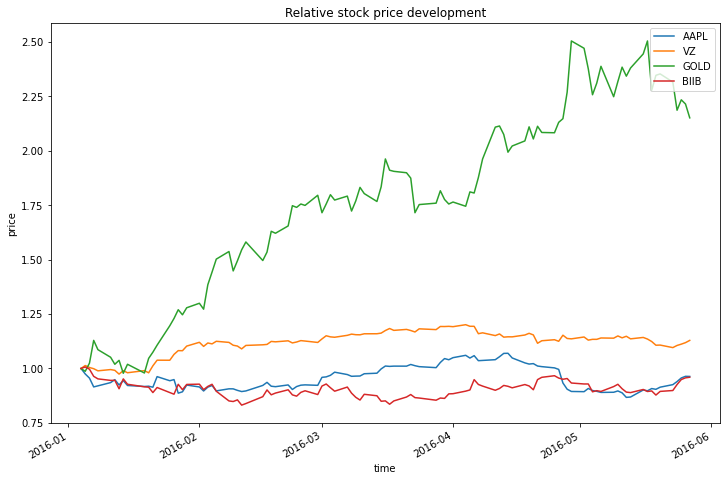

In [646]:
st_data.plot_stock_data()

In [647]:
st_data.calculate_rolling_stats()

In [648]:
st_data.calculate_bollinger_bands()


In [649]:
st_data.calculate_daily_returns()

In [650]:
st_data.calculate_momentum()


In [651]:
st_data.create_indicator_dataframe()
st_data.indicator_df

,Date,Symbol,Adj Close,Daily Returns,SMA,Momentum,Upper Band,Lower Band
0,2016-01-04,AAPL,24.364536,0.000000,0.933355,0.000000,0.987652,0.879058
1,2016-01-05,AAPL,23.753977,-0.025059,0.933355,0.000000,0.987652,0.879058
2,2016-01-06,AAPL,23.289116,-0.019570,0.933355,0.000000,0.987652,0.879058
3,2016-01-07,AAPL,22.306208,-0.042205,0.933355,0.000000,0.987652,0.879058
4,2016-01-08,AAPL,22.424154,0.005288,0.933355,0.000000,0.987652,0.879058
...,...,...,...,...,...,...,...,...
97,2016-05-23,BIIB,264.850006,0.004513,0.911905,-0.005296,0.958940,0.864871
98,2016-05-24,BIIB,272.940002,0.030546,0.910419,0.035747,0.953258,0.867579
99,2016-05-25,BIIB,279.700012,0.024767,0.910357,0.058307,0.952958,0.867757
100,2016-05-26,BIIB,282.000000,0.008223,0.910514,0.089981,0.953806,0.867221


## II. MACHINE LEARNING PIPELINE 

### 1. Create train and test data and standardize

In [681]:
from sklearn import preprocessing

def create_train_test_data(indicator_df, symbol, train_size=0.8, start_pred='2016-05-15', end_pred='2016-05-31'):
    ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
        INPUT:
        indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
        symbol - str - symbol of the listed company for which you want to predict stock price
        train_size - float - size of train dataset
        start_pred - str - start date of prediction
        end_pred - str - end date of prediction
        OUTPUT:
        pred_days - int - days to be predicted
        Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
        Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
        X_train - nd array - contains the training dataset of the independent variables
        X_test - nd array - contains the test dataset of the independent variables
        X_predict = nd array - contains the data of the independent variable for the prediction period
        time_series_train - 1d array - selected time period of training data
        time_series_test - 1d array - selected time period of test data
        time_series_test - 1d array - predicted time period
        
    '''
    sd = datetime.strptime(start_pred, '%Y-%m-%d')
    ed = datetime.strptime(end_pred, '%Y-%m-%d')
    
    try:
        if sd >= ed:
            raise ValueError('Start date beyound end date')
        else:
            pred_days = (ed-sd).days

            train_data_df = indicator_df[(indicator_df['Symbol']==symbol) & (indicator_df['Date'] < start_pred)].copy()

            train_ct = int(train_data_df[train_data_df['Symbol']==symbol].shape[0] * train_size)
            test_ct = train_data_df[train_data_df['Symbol']==symbol].shape[0] - train_size

            X_train_base = train_data_df[train_data_df['Symbol']==symbol].iloc[:(train_ct-pred_days),3:9] 
            Y_train_base = train_data_df[train_data_df['Symbol']==symbol].iloc[pred_days:train_ct,2]
            
            X_test_base = train_data_df[train_data_df['Symbol']==symbol].iloc[train_ct:(-pred_days),3:9]
            Y_test_base = train_data_df[train_data_df['Symbol']==symbol].iloc[(train_ct+pred_days):,2]
            
            X_predict_base = train_data_df[train_data_df['Symbol']==symbol].iloc[(-pred_days):,3:9]
            
            
            X_train = preprocessing.scale(X_train_base) 
            Y_train = preprocessing.scale(Y_train_base)

            X_test = preprocessing.scale(X_test_base)
            Y_test = preprocessing.scale(Y_test_base)

            X_predict = preprocessing.scale(X_predict_base)            

            time_series_train = train_data_df[train_data_df['Symbol']==symbol].iloc[pred_days:train_ct,0].values
            time_series_test = train_data_df[train_data_df['Symbol']==symbol].iloc[(train_ct+pred_days):,0].values
            time_series_predict = pd.date_range(start_pred, periods=pred_days).tolist()
            

            return pred_days, X_train, Y_train, X_test, Y_test, X_predict, time_series_train, time_series_test, time_series_predict
    
    except ValueError:
        raise
        

In [682]:
pred_days, X_train, Y_train, X_test, Y_test, X_predict, time_series_train, time_series_test, time_series_predict = create_train_test_data(indicator_model_df, symbol='AAPL', train_size=0.8)
pred_days, X_train, Y_train, X_test, Y_test, X_predict, time_series_train, time_series_test, time_series_predict

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by the scale function.

In [655]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([ 5.43394567e-19,  6.95545046e-17,  1.08678913e-17,  0.00000000e+00,
        -6.95545046e-17]),
 array([1., 1., 1., 1., 1.]))

### 2. Setup and validate different models

In [656]:
from sklearn import linear_model

from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score


In [657]:
# Evaluate model performance and plot data
def evaluate_model_performance(Y_test, Y_predict, Y_future_predict, time_series_test, timer_series_predict):
    ''' '''
    rmse = np.sqrt(np.sum((Y_test - Y_predict) **2)/len(Y_predict)) #(root mean squared error)
    mse = mean_squared_error(Y_test, Y_predict)
    corr = np.corrcoef(x=Y_test, y=Y_predict)
    mae = mean_absolute_error(Y_test, Y_predict)
    r2 = r2_score(Y_test, Y_predict)
    
    fig = plt.figure(figsize=(12,8))

    plt.plot(time_series_test, Y_test, color='lightblue', linewidth=2, label='test data')
    plt.plot(time_series_test, Y_predict, color='red',  linewidth=2, label='predicted data')
    plt.plot(time_series_predict, Y_future_predict, color='green',  linewidth=2, label='future data')
    plt.legend()
    
    return rmse, mse, mae, r2 , corr

In [658]:
# Lasso LARS

lassolars = linear_model.LassoLars(alpha = 0.1)
lassolars.fit(X_train, Y_train)
Y_predict = lassolars.predict(X_test)
Y_future_predict = lassolars.predict(X_predict)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(1.0,
 1.0,
 0.8779732311990955,
 1.1102230246251565e-16,
 array([[ 1., nan],
        [nan, nan]]))

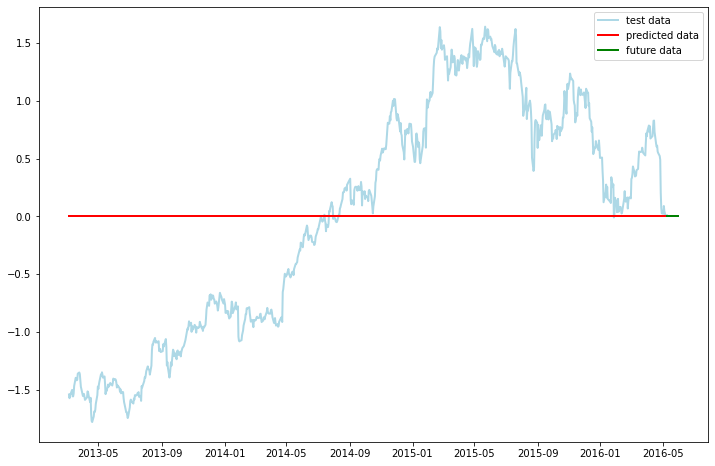

In [659]:
evaluate_model_performance(Y_test, Y_predict, Y_future_predict, time_series_test, time_series_predict)

In [599]:
# Setup different models (regressors)

knn = KNeighborsRegressor(n_neighbors=4)  #weights='distance'
model1 = AdaBoostRegressor(base_estimator=knn, random_state=42)
model2 = SVR(kernel='poly', verbose=True, degree=3, max_iter=1000000)
model3 = RandomForestRegressor(random_state=42, criterion='mae', n_estimators=50, min_samples_split=8)

model1.fit(X_train, Y_train)
model2.fit(X_train, Y_train)
model3.fit(X_train, Y_train)

Y1_predict = model1.predict(X_test)
Y2_predict = model2.predict(X_test)
Y3_predict = model3.predict(X_test)

Y1_future_predict = model1.predict(X_predict)
Y2_future_predict = model2.predict(X_predict)
Y3_future_predict = model3.predict(X_predict)

[LibSVM]

In [600]:
Y_predict = np.array([Y1_predict, Y2_predict, Y3_predict]).mean(axis=0)
Y_predict

array([-0.23239728, -0.202709  , -0.19650769, ..., -0.36968018,
       -0.361146  , -0.40064823])

In [601]:
Y_future_predict = np.array([Y1_future_predict, Y2_future_predict, Y3_future_predict]).mean(axis=0)
Y_future_predict

array([ 1.51970467,  1.23069605,  0.78675006,  0.20248017,  0.10581649,
       -0.09609648, -0.21003847, -0.46566287, -0.56703705, -0.54379817,
       -0.43672018, -0.39965853, -0.54835454, -0.53868529, -0.51501298])

(0.8241501280321265,
 0.6792234335353705,
 0.5807348846205749,
 0.3207765664646294,
 array([[1.        , 0.58949984],
        [0.58949984, 1.        ]]))

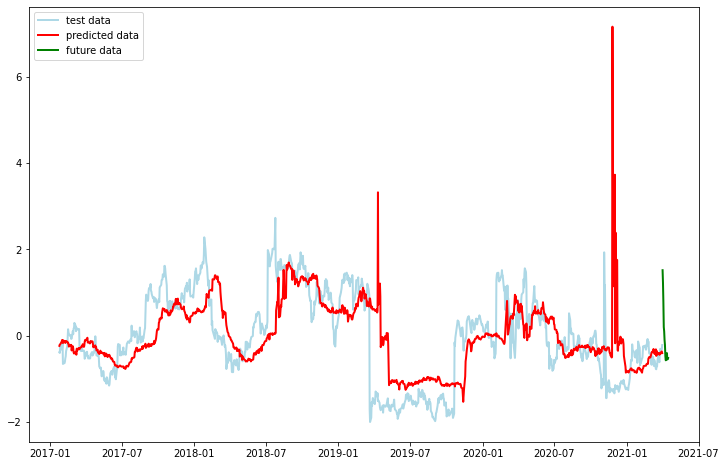

In [603]:
evaluate_model_performance(Y_test, Y_predict, Y_future_predict, time_series_test, time_series_predict)

In [555]:
Y_future_predict, time_series_predict

(array([15.71337164, 13.57759172, 11.62356223, 10.55604512,  9.89210891,
         8.69663854,  6.60910405,  6.35827374,  6.21733067,  4.38049274,
         4.9611782 ,  4.85436813,  3.87324495,  3.61981974,  3.56567641]),
 [Timestamp('2021-04-01 00:00:00', freq='D'),
  Timestamp('2021-04-02 00:00:00', freq='D'),
  Timestamp('2021-04-03 00:00:00', freq='D'),
  Timestamp('2021-04-04 00:00:00', freq='D'),
  Timestamp('2021-04-05 00:00:00', freq='D'),
  Timestamp('2021-04-06 00:00:00', freq='D'),
  Timestamp('2021-04-07 00:00:00', freq='D'),
  Timestamp('2021-04-08 00:00:00', freq='D'),
  Timestamp('2021-04-09 00:00:00', freq='D'),
  Timestamp('2021-04-10 00:00:00', freq='D'),
  Timestamp('2021-04-11 00:00:00', freq='D'),
  Timestamp('2021-04-12 00:00:00', freq='D'),
  Timestamp('2021-04-13 00:00:00', freq='D'),
  Timestamp('2021-04-14 00:00:00', freq='D'),
  Timestamp('2021-04-15 00:00:00', freq='D')])

### 3. Put all the above into one class

In [359]:
class ModelStockPrice():
    def __init__(self, start_predict=None, end_predict=None, pred_days=7):
        '''Create an instance of the model to predict stockprice'''
        
        self.start_predict = start_predict
        self.end_predict = end_predict
        self.pred_days = pred_days
        #self.knn = KNeighborsRegressor(weights='distance')
        
        # self.model = AdaBoostRegressor(base_estimator=self.knn, random_state=42)
        self.model = RandomForestRegressor(random_state=42, criterion='mae',
                                             n_estimators=30, min_samples_split=5)


    def create_train_test_data(self, stockdata, symbol, train_size=0.8, start_pred='2021-04-01', end_pred='2021-04-16'):
        ''' Splits the indicator dataframe into a train and test dataset and standardizes the data of the indipendent variable
            INPUT:
            indicator_df - dataframe object - dataframe which contains the Adj Close and different indicators for each symbol
            symbol - str - symbol of the listed company for which you want to predict stock price
            train_size - float - size of train dataset
            start_pred - str - start date of prediction
            end_pred - str - end date of prediction
            OUTPUT:
            pred_days - int - days to be predicted
            Y_train - 1d array - contains the training dataset of the dependent variable (stock price)
            Y_test - 1d array - contains the test dataset of the dependent variable (stock price)
            X_train - nd array - contains the training dataset of the independent variables
            X_test - nd array - contains the test dataset of the independent variables
            X_predict = nd array - contains the data of the independent variable for the prediction period
            time_series_train - 1d array - selected time period of training data
            time_series_test - 1d array - selected time period of test data
            time_series_test - 1d array - predicted time period

        '''
        sd = datetime.strptime(start_pred, '%Y-%m-%d')
        ed = datetime.strptime(end_pred, '%Y-%m-%d')

        try:
            if sd >= ed:
                raise ValueError('Start date beyound end date')
            else:
                self.pred_days = (ed-sd).days

                train_data_df = stockdata.indicator_df[(stockdata.indicator_df['Symbol']==symbol) & (stockdata.indicator_df['Date'] < start_pred)].copy()

                train_ct = int(train_data_df[train_data_df['Symbol']==symbol].shape[0] * train_size)
                test_ct = train_data_df[train_data_df['Symbol']==symbol].shape[0] - train_size

                self.X_train = preprocessing.scale(train_data_df[train_data_df['Symbol']==symbol].iloc[:(train_ct-pred_days),3:9]) 
                self.Y_train = train_data_df[train_data_df['Symbol']==symbol].iloc[pred_days:train_ct,2].values

                self.X_test = preprocessing.scale(train_data_df[train_data_df['Symbol']==symbol].iloc[train_ct:(-pred_days),3:9])
                self.Y_test = train_data_df[train_data_df['Symbol']==symbol].iloc[(train_ct+pred_days):,2].values

                self.X_predict = preprocessing.scale(train_data_df[train_data_df['Symbol']==symbol].iloc[(-pred_days):,3:9])


                self.time_series_train = train_data_df[train_data_df['Symbol']==symbol].iloc[pred_days:train_ct,0].values
                self.time_series_test = train_data_df[train_data_df['Symbol']==symbol].iloc[(train_ct+pred_days):,0].values
                self.time_series_predict = pd.date_range(start_pred, periods=pred_days).tolist()


                return self.pred_days, self.X_train, self.Y_train, self.X_test, self.Y_test, self.X_predict, self.time_series_train, self.time_series_test, self.time_series_predict

        except ValueError:
            raise

            
    def fit(self):
        '''Fit the model with training data '''
        self.model.fit(self.X_train, self.Y_train)

    def predict(self):
        '''Predict stockprice '''
        self.Y_predict = self.model.predict(self.X_test)
        self.Y_future_predict = self.model.predict(self.X_predict)
        return self.Y_predict, self.Y_future_predict
    
    def evaluate_model_performance(self):
        '''Evaluate prediction'''
        rmse = np.sqrt(np.sum((self.Y_test - self.Y_predict) **2)/len(self.Y_predict)) # root mean squared error
        corr = np.corrcoef(x=self.Y_test, y=self.Y_predict) # correlation
        mae = mean_absolute_error(self.Y_test, self.Y_predict) # mean absolute error
        r2 = r2_score(self.Y_test, self.Y_predict) # R2 Score
    
        fig = plt.figure(figsize=(12,8))

        plt.plot(self.time_series_test, self.Y_test, color='lightblue', linewidth=2, label='test data')
        plt.plot(self.time_series_test, self.Y_predict, color='red',  linewidth=2, label='predicted data')
        plt.plot(self.time_series_predict, self.Y_future_predict, color='green',  linewidth=2, label='future data')
        plt.legend()
    
        return rmse, corr, mae, r2


    
    

In [362]:
price_reg = ModelStockPrice()

In [363]:
price_reg.create_train_test_data(st_data, 'BIIB')

(15,
 array([[-0.00700028,  3.23409964, -0.0143127 ,  3.04243325,  3.17695677],
        [ 0.06010364,  3.23409964, -0.0143127 ,  3.04243325,  3.17695677],
        [ 0.31251461,  3.23409964, -0.0143127 ,  3.04243325,  3.17695677],
        ...,
        [-1.39353538, -0.46232948, -0.49420638,  0.12737695, -1.09008335],
        [-1.02283343, -0.4127505 , -0.81123632,  0.04689318, -0.89761306],
        [ 1.0923878 , -0.35050411, -0.74467597, -0.10393451, -0.59966919]]),
 array([315.14001465, 301.73999023, 301.57998657, ..., 299.39001465,
        300.26000977, 295.54998779]),
 array([[ 0.13080943,  0.38200189,  0.3180269 ,  0.0490193 ,  0.60040855],
        [-0.42921053,  0.38401271,  0.12773528,  0.05029938,  0.60235295],
        [ 0.12982192,  0.41298722, -0.28016144,  0.04546845,  0.65806554],
        ...,
        [-0.07427724, -0.47701047, -0.18232845, -0.77028562,  0.09396397],
        [-0.33666433, -0.48292167, -0.19155627, -0.76362333,  0.07584333],
        [-0.37490273, -0.49915325, 

In [364]:
price_reg.fit()

In [367]:
Y_predict, Y_future_predict = price_reg.predict()
Y_future_predict

array([375.27366994, 401.66533101, 337.46016541, 320.34699758,
       318.08733724, 310.63433406, 287.78650258, 287.0093338 ,
       263.2596667 , 274.95233485, 230.35949936, 273.28367208,
       271.61650543, 263.82267125, 290.30233409])

(48.36171191019318,
 array([[1.        , 0.48304474],
        [0.48304474, 1.        ]]),
 35.07450993369846,
 -2.7937925009794027)

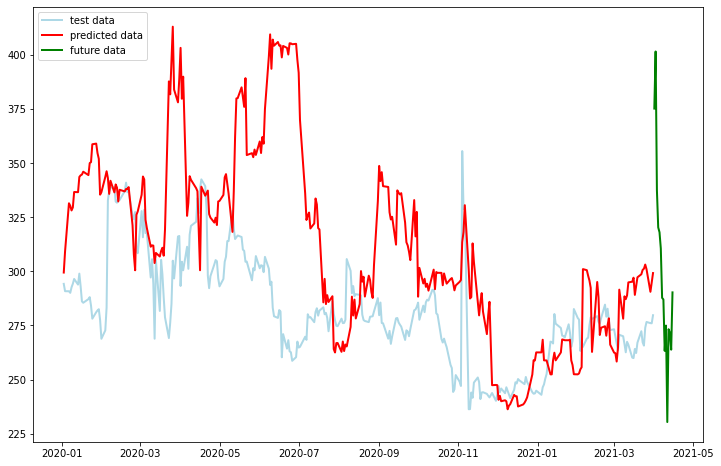

In [366]:
price_reg.evaluate_model_performance()